In [185]:
%%capture
################################
#### do not alter this code ####
################################

!pip install pandas
!pip install jupysql
!pip install matplotlib
!pip install click

import pandas as pd
import matplotlib

In [186]:
%%capture

################################
#### do not alter this code ####
################################

data_folder_path = 'drive/MyDrive/Colab Notebooks/data' # UPDATE THIS! :)

ad_channel_path = data_folder_path + "/ad_channels.csv"
clicks_path = data_folder_path + "/clicks.csv"
locks_path = data_folder_path + "/locks.csv"
sales_path = data_folder_path +  "/sales.csv"
spend_path = data_folder_path + "/spend.csv"
vehicle_path = data_folder_path + "/vehicles.csv"

ad_channels=pd.read_csv(ad_channel_path)
clicks=pd.read_csv(clicks_path)
locks=pd.read_csv(locks_path)
sales=pd.read_csv(sales_path)
spend=pd.read_csv(spend_path)
vehicles=pd.read_csv(vehicle_path)

%load_ext sql
%sql sqlite://

%sql --persist ad_channels
%sql --persist clicks
%sql --persist locks
%sql --persist sales
%sql --persist spend
%sql --persist vehicles

# Solution to Q1 in SQL

In [187]:
%%sql

# ad_channels has a column named in the format category-partner_campaign,
# we break this down to three new columns of the names: category, partner and campaign.

CREATE TEMPORARY TABLE IF NOT EXISTS new_ad_channels AS
    SELECT
        channel_id,
        SUBSTRING_INDEX(channel, '-', 1) AS category,
        SUBSTRING_INDEX(SUBSTRING_INDEX(channel, '-', -1), '_', 1) AS partner,
        SUBSTRING_INDEX(channel, '_', -1) AS campaign
    FROM ad_channels;

# calculate ad_spend per channel id
CREATE TEMPORARY TABLE IF NOT EXISTS ad_spend AS
    SELECT channel_id, SUM(spend) AS total_spend
    FROM spend
    GROUP BY channel_id;

# calculate no.of clicks for each channel id
CREATE TEMPORARY TABLE IF NOT EXISTS clicks_per_channel AS
    SELECT channel_id, COUNT(*) AS clicks
    FROM clicks
    GROUP BY channel_id;

# calculate cost per click for each category
SELECT n.category,
       SUM(s.total_spend) / SUM(c.clicks) AS cost_per_click
FROM clicks_per_channel c
JOIN ad_spend s ON c.channel_id = s.channel_id
JOIN new_ad_channels n ON c.channel_id = n.channel_id
GROUP BY n.category
ORDER BY cost_per_click ASC;


Running query in 'sqlite://'

category,cost_per_click
Search Engine,1.2580487572813484
Social Media,1.3159621880071934
Online Video,2.137102202023481
Third Party Listing,2.9716660327120583
Finance Partnership,3.2072675774741746


# Solution to Q2 in SQL

In [188]:
%%sql

# create a temporary table to store sorted clicks to get first touch
CREATE TEMP TABLE IF NOT EXISTS ranked_clicks AS
    SELECT user_id,
           click_datetime,
           channel_id,
           ROW_NUMBER() OVER (PARTITION BY user_id ORDER BY click_datetime) AS row_num
    FROM clicks;

# create a temporary table to store first touch for each user
CREATE TEMP TABLE IF NOT EXISTS first_touch AS
    SELECT user_id,
            click_datetime,
            channel_id
    FROM ranked_clicks
    WHERE row_num =1;

# ad_channels has a column named in the format category-partner_campaign,
# we break this down to three new columns of the names: category, partner and campaign.
CREATE TEMPORARY TABLE IF NOT EXISTS new_ad_channels AS
    SELECT
        channel_id,
        SUBSTRING_INDEX(channel, '-', 1) AS category,
        SUBSTRING_INDEX(SUBSTRING_INDEX(channel, '-', -1), '_', 1) AS partner,
        SUBSTRING_INDEX(channel, '_', -1) AS campaign
    FROM ad_channels;

# print top 3 campaigns with most sales generated by first touch attribution
SELECT campaign, count(*) num_sales
FROM sales
JOIN first_touch ft ON sales.user_id = ft.user_id
JOIN new_ad_channels nac ON nac.channel_id = ft.channel_id
GROUP BY campaign
ORDER BY num_sales DESC
LIMIT 3

Running query in 'sqlite://'

campaign,num_sales
Sedan,265
Convertible,187
25+,175


# Python Code for all the questions (1-8)

### Functions and their description!

In [189]:
# ad_channels has a column named in the format category-partner_campaign,
# we break this down to three new columns of the names: category, partner and campaign.

def create_new_columns_ad_channels():

    # create a new ad_channels dataframe with split column names
    new_ad_channels_df = ad_channels.copy()

    # Splitting the 'channel_name' column into 'category', 'partner', and 'campaign'
    new_ad_channels_df[['category', 'partner', 'campaign']] = new_ad_channels_df['channel'].str.split(r'[-_]', expand=True)

    # Handling the case when there's no campaign
    new_ad_channels_df['campaign'].fillna(new_ad_channels_df['partner'], inplace=True)

    return new_ad_channels_df

In [190]:
# we identify the first touch for every user_id and store that in this dataframe.
# first touch attribution a marketing technique where we care a lot about the
# first channel an user interacts with first.

def create_first_touch_df():
    # sort all the clicks by the datetime in asc order
    sorted_clicks_df = clicks.sort_values(by='click_datetime')
    first_touch_df = sorted_clicks_df.drop_duplicates(subset=['user_id'], keep='first')

    return first_touch_df

# we identify the last touch (last interaction with a marketing channel)
# for every user_id and store that in this dataframe.
def create_last_touch_df():
    # sort all the clicks by the datetime in asc order
    sorted_clicks_df = clicks.sort_values(by='click_datetime')
    last_touch_df = sorted_clicks_df.drop_duplicates(subset=['user_id'], keep='last')

    return last_touch_df

In [191]:
def calculate_sales_per_channel_id():
    # CHANGE THE CODE TO USE A DIFF DF FROM sales BY DROPPING SOME NULL USER_IDs
    sales_per_user_id_df = sales.groupby('user_id').size().reset_index(name='no_of_sales')

    # create first touch df by calling a function
    first_touch_df = create_first_touch_df()

    # map the sales for each user_id and attribute that to a channel based on the first touch
    sales_per_user_id_merged_first_touch_df = pd.merge(sales_per_user_id_df, first_touch_df, on = 'user_id')

    # count the sales for each channel id
    sales_per_channel_id_df = pd.DataFrame(sales_per_user_id_merged_first_touch_df.groupby('channel_id')['no_of_sales'].sum())

    return sales_per_channel_id_df

### Code for Q1

In [192]:
# solution to q1

# cost per click is the ratio of advertising spend to total no.of clicks

def calculate_cost_per_click_for_each_channel_id():
    # calculate ad_spend per channel id
    ad_spend_df = spend.groupby('channel_id')['spend'].sum().reset_index()

    # calculate no.of clicks for each channel id
    no_of_clicks_df = clicks.groupby('channel_id').size().reset_index(name='clicks')

    # combine the dataframes of ad spend per channel with no.of clicks per channel
    # and further merge that with the dataframe with split channel names
    ad_spend_merged_no_of_clicks_df = pd.merge(no_of_clicks_df, ad_spend_df, on = 'channel_id')

    cost_per_click_for_each_channel_id_df = ad_spend_merged_no_of_clicks_df.groupby('channel_id').agg({'spend': 'sum', 'clicks' : 'sum'}).reset_index()

    cost_per_click_for_each_channel_id_df['cost_per_click'] = cost_per_click_for_each_channel_id_df['spend'] / cost_per_click_for_each_channel_id_df['clicks']

    return cost_per_click_for_each_channel_id_df

def calculate_cost_per_click_for_each_category():
    # create a new df with split channel names by calling a function
    new_ad_channels_df = create_new_columns_ad_channels()

    # call the above function to calculate cost per click for each channel
    cost_per_click_for_each_channel_id_df = calculate_cost_per_click_for_each_channel_id()

    #combine cost per click for each channel_id with the new segregated ad channel names
    cost_per_click_df_merged_new_ad_channels_df = pd.merge(cost_per_click_for_each_channel_id_df, new_ad_channels_df, on = 'channel_id')

    # aggregate and calculate the total ad spend per catergory
    # and also the total no.of clicks per category
    cost_per_click_for_each_category_df = cost_per_click_df_merged_new_ad_channels_df.groupby('category').agg({'spend': 'sum', 'clicks' : 'sum'}).reset_index()

    #calculate the cost per click for each category
    cost_per_click_for_each_category_df['cost_per_click'] = cost_per_click_for_each_category_df['spend'] / cost_per_click_for_each_category_df['clicks']

    return cost_per_click_for_each_category_df

def category_with_least_cpc():
    # call the function to calculate cost per click
    cost_per_click_for_each_category_df = calculate_cost_per_click_for_each_category()

    # find the category with min cost per click
    min_cpc_index = cost_per_click_for_each_category_df['cost_per_click'].idxmin()
    category_with_least_cpc = cost_per_click_for_each_category_df.loc[min_cpc_index, 'category']

    return category_with_least_cpc

##### print solution to q1

print("Category with the least CPC value:", category_with_least_cpc(), "\n\n\n\n\n")

calculate_cost_per_click_for_each_category().sort_values(by = 'cost_per_click')

Category with the least CPC value: Search Engine 







,category,spend,clicks,cost_per_click
2,Search Engine,119000.09,94591,1.258049
3,Social Media,29999.99,22797,1.315962
1,Online Video,39500.06,18483,2.137102
4,Third Party Listing,62500.08,21032,2.971666
0,Finance Partnership,38500.04,12004,3.207268


### Code for Q2

In [193]:
# solution to q2

def calculate_top_three_campaigns_no_of_sales_generated_first_touch():

    sales_per_channel_id_df = calculate_sales_per_channel_id()

    # create df with split channel names by calling a function
    new_ad_channels_df = create_new_columns_ad_channels()

    # map the sales per each channel id with the new_ad_channels df
    sales_per_channel_id_merged_ad_channels_df = pd.merge(sales_per_channel_id_df, new_ad_channels_df, on = 'channel_id')

    # calculate the number of sales per campaign
    aggregate_sales_by_campaign_df = pd.DataFrame(sales_per_channel_id_merged_ad_channels_df.groupby('campaign')['no_of_sales'].sum()).reset_index()

    # identify the top three campaigns by no.of sales generated based on first touch attribution
    top_three_campaigns_by_sales_df = aggregate_sales_by_campaign_df.sort_values(by = 'no_of_sales', ascending = False).head(3)

    return top_three_campaigns_by_sales_df#['campaign'].tolist()

##### print solution to q2

# top three campaigns with most sales:
calculate_top_three_campaigns_no_of_sales_generated_first_touch()


,campaign,no_of_sales
8,Sedan,265
1,Convertible,187
0,25+,175


### Solution to Q3

In [194]:
# solution to q3

def calculate_monthly_sales_oct_to_dec_per_campaign():
    # make sure all the time values are consistent in the sales df
    sales_time_adjusted_df = sales
    sales_time_adjusted_df['sale_datetime'] = pd.to_datetime(sales_time_adjusted_df['sale_datetime'])

    # filter only sales from oct to dec
    # and assign month value of 10, 11 or 12
    # based on the sale month for each sale
    month_filtered_sales_df = sales_time_adjusted_df[sales_time_adjusted_df['sale_datetime'].dt.month.isin([10, 11, 12])]
    month_filtered_sales_df = month_filtered_sales_df[['user_id','sale_id', 'sale_datetime']].copy()
    month_filtered_sales_df['month'] = month_filtered_sales_df['sale_datetime'].dt.month

    # create first touch df by calling a function
    first_touch_df = create_first_touch_df()

    # map filtered sales with channel_id based on first touch attribution
    first_touch_merged_month_filtered_sales_df = pd.merge(month_filtered_sales_df, first_touch_df, on = 'user_id', how = 'left')

    # drop rows where channel_id is NULL
    merged_month_filtered_sales_cleaned_df = first_touch_merged_month_filtered_sales_df.dropna(subset=['channel_id'])
    merged_month_filtered_sales_cleaned_df = merged_month_filtered_sales_cleaned_df[['sale_id','month','channel_id']].copy()

    # create a pivot table to get counts of sales per month and channel_id
    pivot_table = merged_month_filtered_sales_cleaned_df.pivot_table(index='channel_id', columns='month', aggfunc='size', fill_value=0)

    # rename columns for clarity
    pivot_table.columns = ['sales_in_oct', 'sales_in_nov', 'sales_in_dec']

    # reset index to make channel_id a column instead of index
    oct_to_dec_monthly_sales_per_channel_id_df = pivot_table.reset_index()

    # create a new df with split channel names
    new_ad_channels_df = create_new_columns_ad_channels()

    # map the monthly sales per channel with the campaign, category, and partner.
    final_sales_merged_new_ad_channels_df = pd.merge(oct_to_dec_monthly_sales_per_channel_id_df, new_ad_channels_df, on = 'channel_id')

    #calculate monthly (oct - dec) sales per each campaign
    oct_to_dec_monthly_sales_per_campaign_df = pd.DataFrame(final_sales_merged_new_ad_channels_df.groupby('campaign').agg({'sales_in_oct': 'sum', 'sales_in_nov': 'sum', 'sales_in_dec': 'sum'})).reset_index()

    return oct_to_dec_monthly_sales_per_campaign_df

calculate_monthly_sales_oct_to_dec_per_campaign()

,campaign,sales_in_oct,sales_in_nov,sales_in_dec
0,25+,59,36,55
1,Convertible,76,28,34
2,Debit Dharma,44,16,32
3,Giving Vine,41,11,27
4,HeadLedger,30,20,25
5,KnickKnack,24,12,11
6,ManualBarter,22,10,23
7,RealTruck,29,10,27
8,Sedan,89,27,38
9,Teen,14,0,0


In [195]:
def calcualte_month_over_month_growth_or_decline_in_sales():

  oct_to_dec_monthly_sales_per_campaign_df = calculate_monthly_sales_oct_to_dec_per_campaign()

  # Calculate month-over-month growth/decline
  oct_to_dec_monthly_sales_per_campaign_df['growth_nov_to_oct'] = (oct_to_dec_monthly_sales_per_campaign_df['sales_in_nov'] - oct_to_dec_monthly_sales_per_campaign_df['sales_in_oct']) / oct_to_dec_monthly_sales_per_campaign_df['sales_in_oct']
  oct_to_dec_monthly_sales_per_campaign_df['growth_dec_to_nov'] = (oct_to_dec_monthly_sales_per_campaign_df['sales_in_dec'] - oct_to_dec_monthly_sales_per_campaign_df['sales_in_nov']) / oct_to_dec_monthly_sales_per_campaign_df['sales_in_nov']

  # Replace any NaN or infinite values with 0, in case of division by 0
  # oct_to_dec_monthly_sales_per_campaign_df.replace([np.inf, -np.inf], np.nan, inplace=True)
  # oct_to_dec_monthly_sales_per_campaign_df.fillna(0, inplace=True)

  return oct_to_dec_monthly_sales_per_campaign_df
calcualte_month_over_month_growth_or_decline_in_sales().sort_values(by = 'growth_nov_to_oct')
#calcualte_month_over_month_growth_or_decline_in_sales().sort_values(by = 'growth_dec_to_nov')

,campaign,sales_in_oct,sales_in_nov,sales_in_dec,growth_nov_to_oct,growth_dec_to_nov
9,Teen,14,0,0,-1.000000,NaN
3,Giving Vine,41,11,27,-0.731707,1.454545
8,Sedan,89,27,38,-0.696629,0.407407
7,RealTruck,29,10,27,-0.655172,1.700000
2,Debit Dharma,44,16,32,-0.636364,1.000000
1,Convertible,76,28,34,-0.631579,0.214286
10,Truck,60,24,38,-0.600000,0.583333
6,ManualBarter,22,10,23,-0.545455,1.300000
5,KnickKnack,24,12,11,-0.500000,-0.083333
0,25+,59,36,55,-0.389831,0.527778


### Code for Q4

In [196]:
# solution to q4

# customer acquisition cost is the ratio of advertising spend to the no.of sales

def calculate_customer_acquisition_cost_for_each_channel_id():

    sales_per_channel_id_df = calculate_sales_per_channel_id()

    # calculate ad_spend for each channel
    ad_spend_df = spend.groupby('channel_id')['spend'].sum().reset_index()

    # we merge sales for each channel_id with the ad spend
    sales_per_channel_id_merged_ad_spend_df = pd.merge(sales_per_channel_id_df, ad_spend_df, on = 'channel_id')

    customer_acquisition_cost_for_each_channel_id_df = sales_per_channel_id_merged_ad_spend_df.groupby('channel_id').agg({'no_of_sales': 'sum', 'spend' : 'sum'}).reset_index()

    #calculate the customer acquisition cost for each partner
    customer_acquisition_cost_for_each_channel_id_df['customer_acquisition_cost'] = customer_acquisition_cost_for_each_channel_id_df['spend'] / customer_acquisition_cost_for_each_channel_id_df['no_of_sales']

    return customer_acquisition_cost_for_each_channel_id_df

def calculate_customer_acquisition_cost_for_each_partner():
    # create a new df with split channel names
    new_ad_channels_df = create_new_columns_ad_channels()

    # call the above function to calculate customer acquisition cost for each channel
    customer_acquisition_cost_for_each_channel_id_df = calculate_customer_acquisition_cost_for_each_channel_id()

    # map the above per channel_id data with the campaign, category, and partner.
    sales_per_channel_id_merged_ad_spend_df = pd.merge(customer_acquisition_cost_for_each_channel_id_df, new_ad_channels_df, on = 'channel_id')

    # aggregate and calculate the total ad spend per partner
    # and also the total no.of sales per partner
    customer_acquisition_cost_df = sales_per_channel_id_merged_ad_spend_df.groupby('partner').agg({'no_of_sales': 'sum', 'spend' : 'sum'}).reset_index()

    #calculate the customer acquisition cost for each partner
    customer_acquisition_cost_df['customer_acquisition_cost'] = customer_acquisition_cost_df['spend'] / customer_acquisition_cost_df['no_of_sales']

    return customer_acquisition_cost_df

def partner_with_least_cac():
    # call the function to calculate cost per click
    customer_acquisition_cost_for_each_partner_df = calculate_customer_acquisition_cost_for_each_partner()

    # find the category with min cost per click
    min_cpc_index = customer_acquisition_cost_for_each_partner_df['customer_acquisition_cost'].idxmin()
    partner_with_least_cac = customer_acquisition_cost_for_each_partner_df.loc[min_cpc_index, 'partner']

    return partner_with_least_cac

##### print solution to q4

print("Partner with the least Customer Acquisition Cost value:", partner_with_least_cac(), "\n\n\n\n\n\n")

calculate_customer_acquisition_cost_for_each_partner().sort_values(by = 'customer_acquisition_cost')

Partner with the least Customer Acquisition Cost value: Debit Dharma 








,partner,no_of_sales,spend,customer_acquisition_cost
2,Debit Dharma,137,19999.99,145.985328
3,Giving Vine,108,18500.05,171.296759
5,Hooli,423,80000.05,189.125414
1,Datankle,98,20000.02,204.081837
4,HeadLedger,97,19999.95,206.185052
6,KnickKnack,47,10000.04,212.766809
9,WeTube,91,19500.04,214.286154
0,Bam,181,39000.04,215.469834
8,RealTruck,66,31250.07,473.485909
7,ManualBarter,60,31250.01,520.833500


### Code for Q5

In [197]:
# solution to q5


def calculate_profit():

    # make sure all the time values are consistent in the sales df
    sales_time_adjusted_df = sales.copy()
    sales_time_adjusted_df['sale_datetime'] = pd.to_datetime(sales_time_adjusted_df['sale_datetime'])

    # make and model make the unique identifier
    combined_df = pd.merge(sales_time_adjusted_df, vehicles, on=['make', 'model'], how='left')

    ##### step 1
    ##### starting value of the profit is avg margin for each vehicle
    combined_df['profit'] = combined_df['avg_margin']

    ##### step 2
    ##### calculate monthly avg apr value

    # filter the DataFrame where 'is_financed' is not equal to 0
    filtered_df = combined_df[combined_df['is_financed'] != 0]

    # group by month and calculate average APR
    avg_apr_per_month = filtered_df.groupby(filtered_df['sale_datetime'].dt.to_period('M'))['apr'].mean()

    # merge the calculated average APR values back into the original DataFrame based on the month
    combined_df['avg_monthly_apr'] = combined_df['sale_datetime'].dt.to_period('M').map(avg_apr_per_month)

    ##### step 3
    ##### calculate apr modifier value for each sale
    combined_df['apr_modifier'] = -0.1  # default value if financed = 0
    mask_financed = (combined_df['is_financed'] != 0)  # mask for financed != 0
    combined_df.loc[mask_financed, 'apr_modifier'] = (combined_df['apr'] - combined_df['avg_monthly_apr']) / combined_df['avg_monthly_apr']

    ##### step 4
    ##### update the profit based on the above calculated apr modifier
    # note that combined_df['profit] initially holds the starting value i.e. avg_margin. we update that in this step
    combined_df['profit'] = combined_df['profit'] * (1 + combined_df['apr_modifier'])

    ##### step 5
    ##### update the profit based on the bodystyle of the vehicle
    mask_trade_in = (combined_df['has_trade_in'] != 0)

    # Sedan or Hatchback
    mask_sedan_hatchback = combined_df['bodystyle'].isin(['Sedan', 'Hatchback'])
    combined_df.loc[mask_sedan_hatchback, 'profit'] += (200 - (combined_df['delivery_distance'] / 2))
    #combined_df.loc[mask_sedan_hatchback, 'profit'] -= combined_df['delivery_distance'] / 2
    combined_df.loc[mask_sedan_hatchback & mask_trade_in, 'profit'] += 400

    # Coupe or SUV
    mask_coupe_suv = combined_df['bodystyle'].isin(['Coupe', 'SUV'])
    combined_df.loc[mask_coupe_suv, 'profit'] -= 0.8 * combined_df['delivery_distance']
    combined_df.loc[mask_coupe_suv & mask_trade_in, 'profit'] += 300  # Trade-in

    # Truck
    mask_truck = combined_df['bodystyle'] == 'Truck'
    combined_df.loc[mask_truck & mask_financed, 'profit'] -= 200 + combined_df['delivery_distance']
    combined_df.loc[mask_truck, 'profit'] -= combined_df['delivery_distance']
    combined_df.loc[mask_truck & mask_trade_in, 'profit'] += 200  # Trade-in

    return combined_df

def calculate_roi_per_channel_id():
    # create first touch df by calling a function
    first_touch_df = create_first_touch_df()

    # map the profit from sales for each user_id and attribute that to a channel based on the first touch
    profit_merged_first_touch_df = pd.merge(calculate_profit(), first_touch_df, on = 'user_id')

    # sum up the profit from sales for each channel id
    profit_per_channel_id_df = pd.DataFrame(profit_merged_first_touch_df.groupby('channel_id')['profit'].sum()).reset_index()

    # calculate ad_spend per channel id
    ad_spend_df = spend.groupby('channel_id')['spend'].sum().reset_index()

    # we merge profit from sales for each channel_id with the ad spend
    profit_per_channel_id_merged_ad_spend_df = pd.merge(profit_per_channel_id_df, ad_spend_df, on = 'channel_id')

    # aggregate and calculate the total ad spend per catergory
    # and also the total profit from sales per category
    roi_per_channel_id_df = profit_per_channel_id_merged_ad_spend_df.groupby('channel_id').agg({'spend': 'sum', 'profit' : 'sum'}).reset_index()

    #calculate the cost per click for each category
    roi_per_channel_id_df['roi'] = roi_per_channel_id_df['profit'] / roi_per_channel_id_df['spend']

    return roi_per_channel_id_df

def roi_per_category():

    # create a new df with split channel names
    new_ad_channels_df = create_new_columns_ad_channels()

    # call the above function calculate roi for each channel
    roi_per_channel_id_df = calculate_roi_per_channel_id()

    # map the profit from sales and ad spend per each channel id with the new_ad_channels df
    roi_variables_merged_ad_channels_df = pd.merge(roi_per_channel_id_df, new_ad_channels_df, on = 'channel_id')

    # aggregate and calculate the total ad spend per catergory
    # and also the total profit from sales per category
    roi_per_category_df = roi_variables_merged_ad_channels_df.groupby('category').agg({'spend': 'sum', 'profit' : 'sum'}).reset_index()

    #calculate the cost per click for each category
    roi_per_category_df['roi'] = roi_per_category_df['profit'] / roi_per_category_df['spend']

    return roi_per_category_df

roi_per_category()

,category,spend,profit,roi
0,Finance Partnership,38500.04,86276.029353,2.240933
1,Online Video,39500.06,52325.194535,1.324686
2,Search Engine,119000.09,203531.659175,1.710349
3,Social Media,29999.99,46401.994393,1.546734
4,Third Party Listing,62500.08,19264.423000,0.308230


#### Code for Q6

In [198]:
# solution to q6

def calculate_avg_clicks_before_lock():

    clicks_time_adjusted_df = clicks.copy()
    locks_time_adjusted_df = locks.copy()

    clicks_time_adjusted_df['click_datetime'] = pd.to_datetime(clicks_time_adjusted_df['click_datetime'])
    locks_time_adjusted_df['lock_datetime'] = pd.to_datetime(locks_time_adjusted_df['lock_datetime'], format = 'mixed', yearfirst = True)

    click_time_merged_lock_time_df = pd.merge(locks_time_adjusted_df, clicks_time_adjusted_df, on = 'user_id', how = 'left')

    # filter rows where 'click_datetime' is less than 'lock_datetime'
    filtered_df = click_time_merged_lock_time_df[click_time_merged_lock_time_df['click_datetime'] < click_time_merged_lock_time_df['lock_datetime']]

    # group by calculate the unique count of 'channel_id'
    result = filtered_df.groupby('lock_id')['channel_id'].nunique()

    # assign the result to the original DataFrame
    click_time_merged_lock_time_df['click_count_before_lock'] = click_time_merged_lock_time_df['lock_id'].map(result)

    # calculate the average clicks for each lock
    # we do not calculate for each user_id because
    # sometimes the users come back for purchase
    interactions_per_lock_id_df = click_time_merged_lock_time_df[['lock_id', 'click_count_before_lock']].drop_duplicates()
    avg_clicks_before_lock_df = interactions_per_lock_id_df['click_count_before_lock'].sum() / len(interactions_per_lock_id_df['lock_id'].unique())

    return avg_clicks_before_lock_df

calculate_avg_clicks_before_lock()


2.967979415338432

### Code for Q7

In [199]:
# solution to q7

def calculate_time_diff_between_sale_and_last_click():
    # make sure all the time values are consistent in the sales df
    sales_time_adjusted_df = sales.copy()
    sales_time_adjusted_df['sale_datetime'] = pd.to_datetime(sales_time_adjusted_df['sale_datetime'])

    sales_time_adjusted_filtered_df = sales_time_adjusted_df[['user_id','sale_id', 'sale_datetime']].copy()

    # create a df with the last interaction of a customer with the marketing channel
    last_touch_df = create_last_touch_df()

    # in this df we capture the last time a customer interacted with
    # one of the marketing channels
    merged_sales_last_touch_df = pd.merge(sales_time_adjusted_filtered_df, last_touch_df, on = 'user_id', how = 'left')
    merged_sales_last_touch_df = merged_sales_last_touch_df.fillna(0)

    # make sure all the time values are consistent in the sales df
    merged_sales_last_touch_df['click_datetime'] = pd.to_datetime(merged_sales_last_touch_df['click_datetime'], format = 'mixed', yearfirst = True)
    merged_sales_last_touch_df['sale_datetime'] = pd.to_datetime(merged_sales_last_touch_df['sale_datetime'])

    # calculate time difference in days using vectorized operations
    merged_sales_last_touch_df['time_diff_in_days'] = (merged_sales_last_touch_df['sale_datetime'] - merged_sales_last_touch_df['click_datetime']).dt.days

    return merged_sales_last_touch_df

def calculate_percent_of_sales_with_no_click_for_90_days():
    merged_sales_last_touch_df = calculate_time_diff_between_sale_and_last_click()
    # filter rows where time difference is greater than 90 days
    rows_greater_than_90_days = merged_sales_last_touch_df[merged_sales_last_touch_df['time_diff_in_days'] > 90]
    return (len(rows_greater_than_90_days) / len(merged_sales_last_touch_df))*100

calculate_percent_of_sales_with_no_click_for_90_days()


3.783382789317508

In [200]:
def calculate_percent_of_sales_with_no_click_for_60_days():
    merged_sales_last_touch_df = calculate_time_diff_between_sale_and_last_click()
    # filter rows where time difference is greater than 60 days
    rows_greater_than_60_days = merged_sales_last_touch_df[merged_sales_last_touch_df['time_diff_in_days'] > 60]

    return (len(rows_greater_than_60_days) / len(merged_sales_last_touch_df))*100

calculate_percent_of_sales_with_no_click_for_60_days()

5.563798219584569

In [201]:
def calculate_percent_of_sales_with_no_click_for_30_days():
    merged_sales_last_touch_df = calculate_time_diff_between_sale_and_last_click()
    # filter rows where time difference is greater than 30 days
    rows_greater_than_30_days = merged_sales_last_touch_df[merged_sales_last_touch_df['time_diff_in_days'] > 30]

    return (len(rows_greater_than_30_days) / len(merged_sales_last_touch_df))*100

calculate_percent_of_sales_with_no_click_for_30_days()

11.350148367952523

### Code for Q8

In [202]:
# solution to q8

customer_acquisition_cost_df = calculate_customer_acquisition_cost_for_each_channel_id()
cost_per_click_df = calculate_cost_per_click_for_each_channel_id()
roi_df = calculate_roi_per_channel_id()

# we calculate the no.of users that interact per channel id
unique_users_per_channel = clicks.groupby('channel_id')['user_id'].nunique().reset_index(name = "no.of users")
unique_users_per_channel

merged_df = pd.merge(customer_acquisition_cost_df, cost_per_click_df, on = ['channel_id', 'spend'], how = 'inner')
merged_df = pd.merge(merged_df, roi_df, on = ['channel_id', 'spend'], how = 'inner')
merged_df = pd.merge(merged_df, unique_users_per_channel, on = 'channel_id', how = 'inner')

merged_df

,channel_id,no_of_sales,spend,customer_acquisition_cost,clicks,cost_per_click,profit,roi,no.of users
0,1,135,24999.95,185.184815,20977,1.191779,41081.485297,1.643263,13310
1,2,174,29999.95,172.413506,29324,1.023051,58713.204697,1.957110,19610
2,3,114,25000.15,219.299561,15392,1.624230,38245.820766,1.529824,12246
3,4,52,11999.94,230.768077,6835,1.755661,15656.097069,1.304681,4962
4,5,91,14999.98,164.834945,12182,1.231323,36801.999216,2.453470,7556
5,6,38,12000.12,315.792632,9881,1.214464,13033.052130,1.086077,8860
6,7,8,5000.04,625.005000,2505,1.996024,3743.740295,0.748742,2344
7,8,90,14999.98,166.666444,7265,2.064691,22047.869223,1.469860,5205
8,9,6,5000.00,833.333333,2370,2.109705,1170.465000,0.234093,2212
9,10,85,14500.04,170.588706,6343,2.285991,25363.120017,1.749176,4449


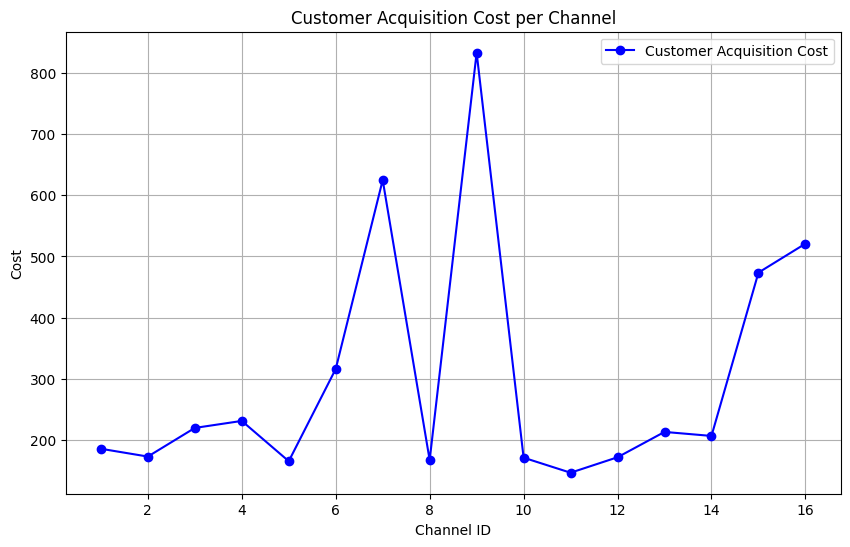

In [203]:
import matplotlib.pyplot as plt

# Plot customer acquisition cost
plt.figure(figsize=(10, 6))
plt.plot(merged_df['channel_id'], merged_df['customer_acquisition_cost'], marker='o', color='b', label='Customer Acquisition Cost')
plt.xlabel('Channel ID')
plt.ylabel('Cost')
plt.title('Customer Acquisition Cost per Channel')
plt.legend()
plt.grid(True)
plt.show()


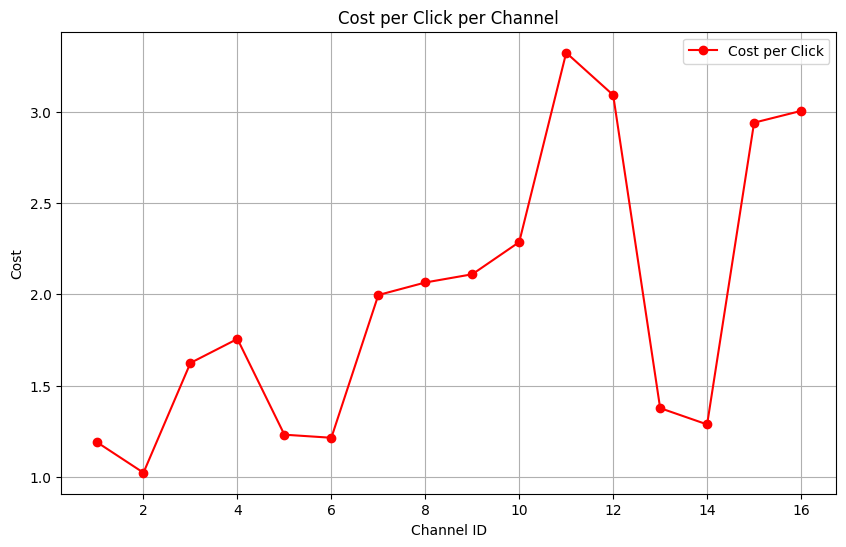

In [204]:
# Plot cost per click
plt.figure(figsize=(10, 6))
plt.plot(merged_df['channel_id'], merged_df['cost_per_click'], marker='o', color='r', label='Cost per Click')
plt.xlabel('Channel ID')
plt.ylabel('Cost')
plt.title('Cost per Click per Channel')
plt.legend()
plt.grid(True)
plt.show()


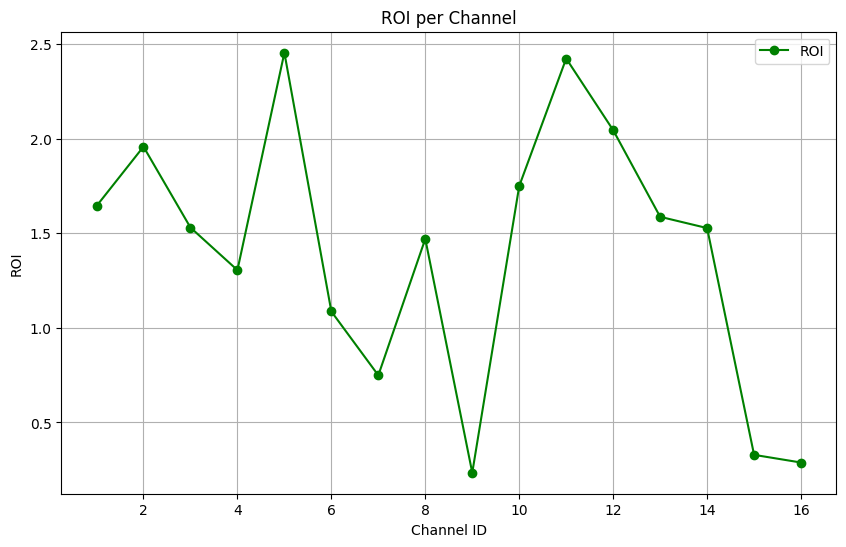

In [205]:
# Plot ROI
plt.figure(figsize=(10, 6))
plt.plot(merged_df['channel_id'], merged_df['roi'], marker='o', color='g', label='ROI')
plt.xlabel('Channel ID')
plt.ylabel('ROI')
plt.title('ROI per Channel')
plt.legend()
plt.grid(True)
plt.show()

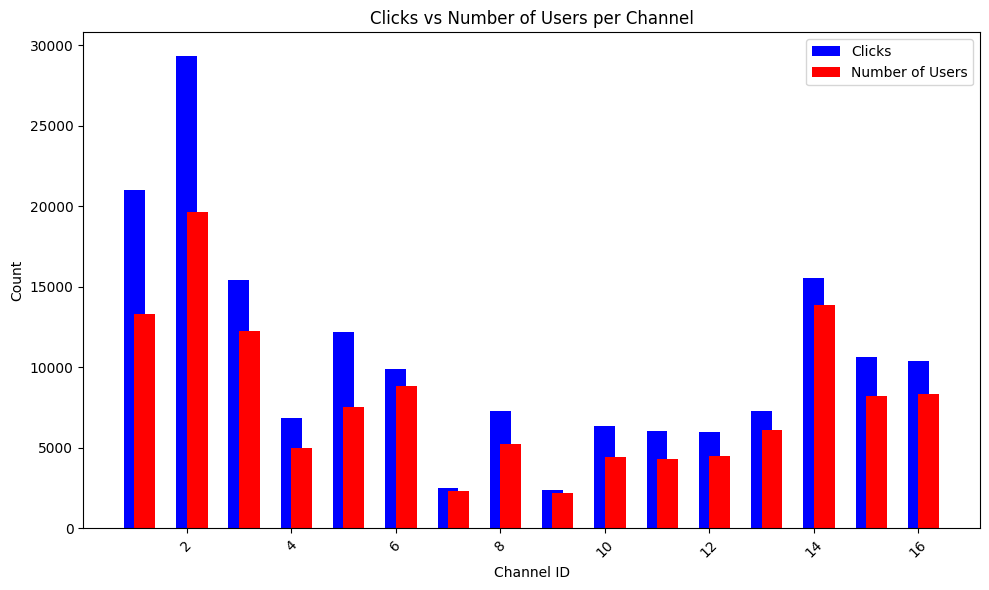

In [206]:
# Setting up the figure
plt.figure(figsize=(10, 6))

# Plotting the bars
plt.bar(merged_df['channel_id'], merged_df['clicks'], color='b', width=0.4, align='center', label='Clicks')
plt.bar(merged_df['channel_id'], merged_df['no.of users'], color='r', width=0.4, align='edge', label='Number of Users')

# Adding labels and title
plt.xlabel('Channel ID')
plt.ylabel('Count')
plt.title('Clicks vs Number of Users per Channel')
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Displaying the plot
plt.tight_layout()
plt.show()


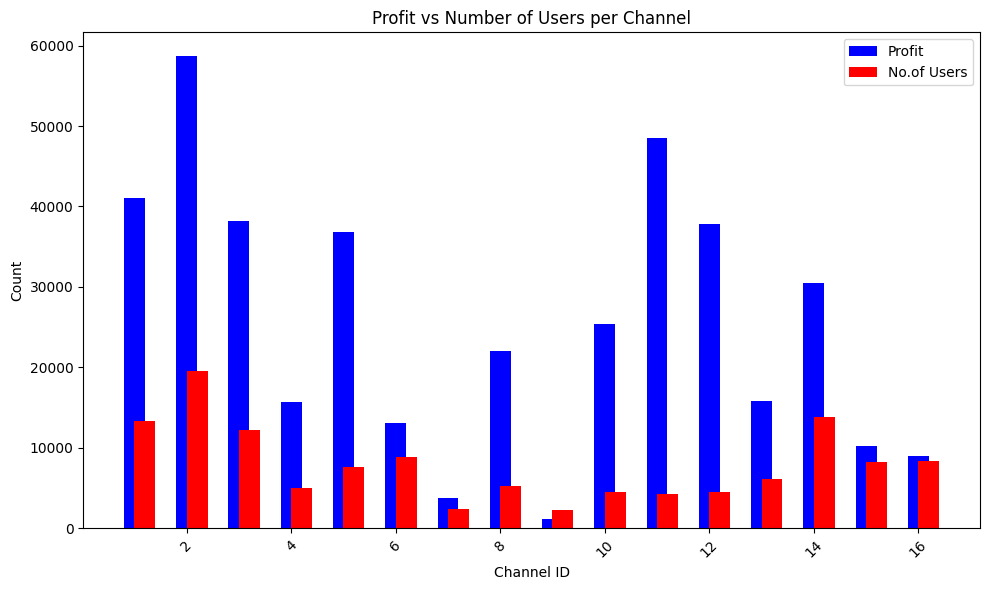

In [207]:
# Setting up the figure
plt.figure(figsize=(10, 6))

# Plotting the bars
plt.bar(merged_df['channel_id'], merged_df['profit'], color='b', width=0.4, align='center', label='Profit')
plt.bar(merged_df['channel_id'], merged_df['no.of users'], color='r', width=0.4, align='edge', label='No.of Users')

# Adding labels and title
plt.xlabel('Channel ID')
plt.ylabel('Count')
plt.title('Profit vs Number of Users per Channel')
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Displaying the plot
plt.tight_layout()
plt.show()
